# Test and Trace resampling

In this notebook, we relax the random sampling assumption by introducing two additional model parameters:

- The testing rate for infected individuals
- The testing rate for non-infected individuals

To estimate these within our model, we slightly adapt our framework to incorporate a random survey that runs parallel to the Test and Trace scheme. This survey records individual attendances in the studied settings but does not record antigen test results. Thus, our model now is now fitted with data from the survey sample and data from the Test and Trace sample.

In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import pystan

In [2]:
# Parameters
P = 10
N = 3*(10 ** 4)
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

t_i = np.random.beta(8, 2, 1)  # Prob(tested | infected)
t_not_i = np.random.beta(2, 20, 1)  # Prob(tested | not-infected)
true_gamma = np.array([t_i, t_not_i])

In [4]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)

# Resampling using testing probabilites conditional on infected
tested = y*np.random.binomial(1, true_gamma[0], N) + (1-y)*np.random.binomial(1, true_gamma[1], N)
y = y[tested == 1]
X_survey = X[tested == 0].reset_index()
X = X[tested == 1].reset_index()

N = X.shape[0]
NA = X_survey.shape[0]

X = X.loc[:, X.columns.str.startswith('O')]
X_survey = X_survey.loc[:, X_survey.columns.str.startswith('O')]
X.info()
X_survey.info()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      8192 non-null   int64
 1   O2      8192 non-null   int64
 2   O3      8192 non-null   int64
 3   O4      8192 non-null   int64
 4   O5      8192 non-null   int64
 5   O6      8192 non-null   int64
 6   O7      8192 non-null   int64
 7   O8      8192 non-null   int64
 8   O9      8192 non-null   int64
 9   O10     8192 non-null   int64
dtypes: int64(10)
memory usage: 640.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21808 entries, 0 to 21807
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      21808 non-null  int64
 1   O2      21808 non-null  int64
 2   O3      21808 non-null  int64
 3   O4      21808 non-null  int64
 4   O5      21808 non-null  int64
 5   O6      21808 non-null  int64
 6   O7      21808 non-null  int64
 7   O8 

In [5]:
# Create model for resampled data
sm = pystan.StanModel(model_name='tt_mod', model_code="""
data {
  int<lower=0> N;                            // number of test observations
  int<lower=0> NA;                           // number of survey observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences of tested individuals
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=0, upper=1> survey[NA,P];        // activity occurrences of surveyed individuals
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
  real<lower=0, upper=1> gamma[2];           // testing rates, given infected status [Pr(T|I) , Pr(T|!I)]
}
model {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  real log_gamma[2];
  real log1m_gamma[2];
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  for(i in 1:2){
    log_gamma[i] = log(gamma[i]);
    log1m_gamma[i] = log1m(gamma[i]);
  }
  log1m_rho = log1m(rho);

  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  gamma ~ uniform(0,1);

  // Likelihood
  for (n in 1:NA) {
    real s = 0.0;
    for (p in 1:P) {
      if (survey[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    target += log_sum_exp((log1m_exp(s)+log1m_gamma[1]), (s+log1m_gamma[2]));
  }
  
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += (log1m_exp(s)+log_gamma[1]);
    } 
    else {
      target += (s+log_gamma[2]);
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_d05201afd006d75d6734dca29fb9e411 NOW.


In [6]:
# Set NUTS parameters
nuts_samples = 1000
nuts_burnin = 500
nuts_chains = 16

In [7]:
# Fit model using test & trace resampling
start = time.time()
model_data = {'N': N, 'NA': NA, 'P': P, 'X': X.to_numpy(),
              'y': y.to_numpy(), 'survey': X_survey.to_numpy()}
fit = sm.sampling(
    data=model_data,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=nuts_chains
)
print(f"{time.time() - start:.02f} seconds elapsed")

2010.34 seconds elapsed


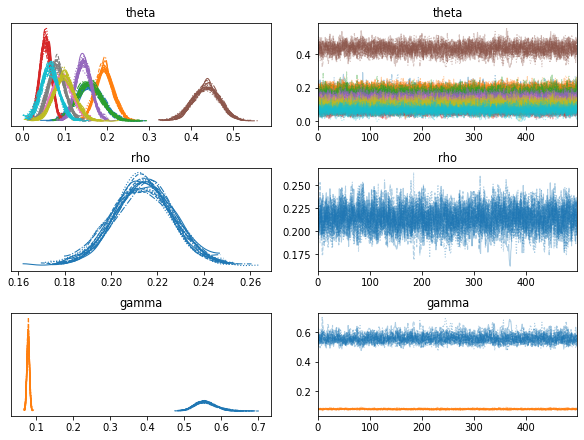

In [9]:
# Evaluate fit with test and trace resample
arviz.plot_trace(fit, figsize=(8, 6));

In [10]:
# View results
print("Inference on fitted model:")
print(fit)
print('')
print('Ground truth:')
print('Setting-specific transmission rates: ', true_transmission_rate)
print('Base rate: ', base_rate)
print('Testing rates: ', true_gamma)

Inference on fitted model:
Inference for Stan model: tt_mod_d05201afd006d75d6734dca29fb9e411.
16 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.16  4.2e-4   0.03    0.1   0.14   0.16   0.18   0.22   5388    1.0
theta[2]    0.19  3.4e-4   0.02   0.15   0.18   0.19   0.21   0.24   3950    1.0
theta[3]    0.16  3.9e-4   0.03   0.11   0.14   0.16   0.18   0.22   5483    1.0
theta[4]    0.05  1.9e-4   0.01   0.03   0.05   0.05   0.06   0.08   5203    1.0
theta[5]    0.14  2.9e-4   0.02   0.11   0.13   0.14   0.16   0.18   4057    1.0
theta[6]    0.44  6.6e-4   0.03   0.37   0.41   0.44   0.46    0.5   2288    1.0
theta[7]    0.09  3.1e-4   0.02   0.05   0.08   0.09   0.11   0.14   6078    1.0
theta[8]    0.08  2.7e-4   0.02   0.04   0.07   0.08   0.09   0.12   5343    1.0
theta[9]     0.1  3.3e-4   0.02   0.05   0.08    0.1   0.11 